**Tabla de contenido**

- [Creando ventanas de datos](#Creando-ventanas-de-datos)
    - [Explorando cómo se entrenan los modelos de aprendizaje profundo para la predicción de series temporales](#Explorando-como-se-entrenan-los-modelos-de-aprendizaje-profundo-para-la-prediccion-de-series-temporales)
    - [Implementando la clase DataWindow](#Implementando-la-clase-DataWindow)
- [Aplicando modelos de referencia](#Aplicando-modelos-de-referencia)
    - [Modelo base de un solo paso](#Modelo-base-de-un-solo-paso)
    - [Modelo base de multiples pasos](#Modelo-base-de-multiples-pasos)
        - [Predecir el último valor conocido](#Predecir-el-ultimo-valor-conocido)
        - [Repetir la secuencia de entrada](#Repetir-la-secuencia-de-entrada)
        - [Mode base de múltiples salidas](#Mode-base-de-multiples-salidas)
- [Próximos pasos](#Proximos-pasos)
- [Resumen](#Resumen)

En el último capítulo, introduje el aprendizaje profundo para la predicción al cubrir las situaciones en las que el aprendizaje profundo es ideal y describir los tres tipos principales de modelos de aprendizaje profundo: paso único, multi-pasos y multi-salida. Luego procedimos con la exploración de datos y la ingeniería de características para eliminar características innecesarias y crear nuevas características que nos ayudarán a predecir el volumen de tráfico. Con esa configuración lista, ahora estamos listos para implementar el aprendizaje profundo para predecir nuestra variable objetivo, que es el volumen de tráfico.

En este capítulo, construiremos una clase reutilizable que creará ventanas de datos. Este paso es probablemente el tema más complicado y útil en esta parte del libro sobre aprendizaje profundo. Aplicar el aprendizaje profundo para la predicción depende de crear ventanas de tiempo adecuadas y especificar las entradas y etiquetas. Una vez que eso esté hecho, verás que implementar diferentes modelos se vuelve increíblemente fácil, y este marco puede reutilizarse para diferentes situaciones y conjuntos de datos.

Una vez que sepas cómo crear ventanas de datos, pasaremos a implementar modelos base, modelos lineales y redes neuronales profundas. Esto nos permitirá medir el rendimiento de estos modelos, y luego podremos pasar a arquitecturas más complejas en los capítulos siguientes.

# Creando ventanas de datos

Comenzaremos creando la clase DataWindow, que nos permitirá formatear los datos adecuadamente para alimentarlos a nuestros modelos de aprendizaje profundo. También agregaremos un método de visualización a esta clase para que podamos visualizar las predicciones y los valores reales.

Antes de sumergirnos en el código y construir la clase DataWindow, sin embargo, es importante entender por qué debemos realizar ventanas de datos para el aprendizaje profundo. Los modelos de aprendizaje profundo tienen una manera particular de ajustarse a los datos, que exploraremos en la próxima sección. Luego pasaremos a implementar la clase DataWindow.


## Explorando como se entrenan los modelos de aprendizaje profundo para la prediccion de series temporales

En la primera mitad de este libro, ajustamos modelos estadísticos, como SARIMAX, en conjuntos de entrenamiento y hicimos predicciones. En realidad, estábamos ajustando un conjunto de funciones predefinidas de un cierto orden (p,d,q)(P,D,Q)m y averiguando qué orden resultaba en el mejor ajuste.

Para los modelos de aprendizaje profundo, no tenemos un conjunto de funciones para probar. En su lugar, dejamos que la red neuronal derive su propia función de tal manera que, al recibir las entradas, genere las mejores predicciones posibles. Para lograr eso, realizamos lo que se llama ventana de datos. Este es un proceso en el cual definimos una secuencia de puntos de datos en nuestra serie temporal y definimos cuáles son las entradas y cuáles son las etiquetas. De esa manera, el modelo de aprendizaje profundo puede ajustarse a las entradas, generar predicciones, compararlas con las etiquetas y repetir este proceso hasta que no pueda mejorar la precisión de sus predicciones.

Vamos a recorrer un ejemplo de ventana de datos. Nuestra ventana de datos utilizará 24 horas de datos para predecir las próximas 24 horas. Probablemente te preguntes por qué estamos utilizando solo 24 horas de datos para generar predicciones. Después de todo, el aprendizaje profundo necesita muchos datos y se utiliza para conjuntos de datos grandes. `La clave radica en la ventana de datos`. Una única ventana tiene 24 pasos de tiempo como entrada para generar una salida de 24 pasos de tiempo. Sin embargo, todo el conjunto de entrenamiento se divide en múltiples ventanas, lo que significa que tenemos muchas ventanas con entradas y etiquetas.

Para hacer la computación más eficiente, los modelos de aprendizaje profundo se entrenan con lotes. Un lote es simplemente una colección de ventanas de datos que se alimentan al modelo para su entrenamiento.

La clase DataWindow que implementaremos en la siguiente sección genera ventanas de datos con entradas que comienzan en t = 0. Luego creará otro conjunto de ventanas de datos, pero esta vez comenzando en t = 1. Luego comenzará en t = 2. Esto continuará hasta que no pueda tener una secuencia de 24 etiquetas consecutivas en el conjunto de entrenamiento.

## Implementando la clase DataWindow

La clase se basa en el ancho de la entrada (input_width), el ancho de la etiqueta (label_width) y el desplazamiento (shift). El ancho de la entrada es simplemente el número de pasos de tiempo que se introducen en el modelo para hacer predicciones. Por ejemplo, dado que tenemos datos horarios en nuestro conjunto de datos, si alimentamos al modelo con 24 horas de datos para hacer una predicción, el ancho de la entrada es 24. Si alimentamos solo 12 horas de datos, el ancho de la entrada es 12.

El ancho de la etiqueta (label_width) es equivalente al número de pasos de tiempo en las predicciones. Si predecimos solo un paso de tiempo, el ancho de la etiqueta (label_width) es 1. Si predicimos un día completo de datos (con datos horarios), el ancho de la etiqueta (label_width) es 24.

Finalmente, el desplazamiento (shift) es el número de pasos de tiempo que separan la entrada de las predicciones. Si predecimos el siguiente paso de tiempo, el desplazamiento (shift) es 1. Si predecimos las próximas 24 horas (con datos horarios), el desplazamiento (shift) es 24. 


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

file_path = lambda file: os.path.join(os.getcwd(),'data',file)
train_df = pd.read_csv(file_path('train.csv'))
val_df = pd.read_csv(file_path('val.csv'))
test_df = pd.read_csv(file_path('test.csv'))

1. Nombre de la columna que deseamos predecir
2. Cree un diccionario con el nombre y el índice de la columna etiqueta. Esto se usará para trazar.
3. Cree un diccionario con el nombre y el índice de cada columna. Esto se usará para separar las entidades de la variable de destino.
4. La función de división devuelve un objeto de división que especifica cómo dividir una secuencia. En este caso, dice
que el segmento de entrada comienza en 0 y termina cuando alcanzamos el input_width.
5. Asigne índices a las entradas. Estos son útiles para trazar.
6. Obtenga el índice en el que comienza la etiqueta. En este caso, es el tamaño total de la ventana menos el ancho de la etiqueta.
7. Los mismos pasos que se aplicaron para las entradas se aplican para las etiquetas.
8. Corta la ventana para obtener las entradas usando el input_slice definido en __init__.
9. Corta la ventana para obtener las etiquetas usando labels_slice definido en __init__.
10. Si tenemos más de un objetivo, apilamos las etiquetas.
11. La forma será [lote, tiempo, características]. En este punto, solo especificamos la dimensión de tiempo y permitimos que las dimensiones de lote y características se definan más tarde.
12. Plotea las entradas. Aparecerán como una línea continua azul con puntos.
13. Grafique las etiquetas o los valores reales. Aparecerán como cuadrados verdes.
14. Traza las predicciones. Aparecerán como cruces rojas.

`Función que crea los tensores`


15. Pase los datos. Esto corresponde a nuestro conjunto de entrenamiento, conjunto de validación o conjunto de prueba.
16. Los objetivos se establecen en Ninguno, ya que son manejados por la función split_to_input_labels.
17. Define la longitud total del arreglo, que es igual a la longitud total de la ventana.
18. Define el número de pasos de tiempo que separan cada secuencia. En nuestro caso, queremos que las secuencias sean consecutivas, así que sequence_stride=1.
19. Baraja las secuencias. Ten en cuenta que los datos aún están en orden cronológico. Simplemente estamos cambiando el orden de las secuencias, lo que hace que el modelo sea más robusto.
20. Defina el número de secuencias en un solo lote. Recuerda que estamos reorganizando las secuencias en un lote. Esto significa que dentro de cada secuencia, los datos están en orden cronológico. Sin embargo, en un lote de 32 secuencias, podemos y debemos barajarlas para hacer que nuestro modelo sea más robusto y menos propenso al sobreajuste.

21. Obtenga un lote de muestra de datos para fines de representación gráfica. Si el lote de muestra no existe, recuperaremos un lote de muestra y lo almacenaremos en caché.


In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, 
                 test_df=test_df,label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns #1
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #2
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #3

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) #4

        self.input_indices = np.arange(self.total_window_size)[self.input_slice] #5 
        self.label_start = self.total_window_size - self.label_width #6

        self.labels_slice = slice(self.label_start, None) #7 
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # 8
        labels = features[:, self.labels_slice, :] # 9

        if self.label_columns is not None: # 10 
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        inputs.set_shape([None, self.input_width, None]) #11 
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    # Método para trazar una muestra de ventanas de datos
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10) # 12
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col,None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels',c='green', s=64) # 13
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :,label_col_index],marker='X', 
                            edgecolors='k', label='Predictions',c='red', s=64) #14
            if n == 0:
                plt.legend()
            plt.xlabel('Time (h)')
        
    # Función que crea los tensores con los datos temporales
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,                              # 15
            targets=None,                           #16
            sequence_length=self.total_window_size, #17
            sequence_stride=1,                      #18
            shuffle=True,                           #19
            batch_size=32                           #20
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    """ 
    Concluiremos nuestra clase DataWindow definiendo algunas propiedades para aplicar 
    la función make_dataset en los conjuntos de entrenamiento, validación y prueba. 
    También crearemos un lote de muestra que almacenaremos en caché dentro de la clase para fines de trazado.
    """
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def sample_batch(self):                          #21
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

Por ahora, la clase DataWindow puede parecer un poco abstracta, pero pronto la utilizaremos para aplicar modelos de referencia. Estaremos utilizando esta clase en todos los capítulos de esta parte del libro sobre aprendizaje profundo, así que poco a poco dominarás este código y apreciarás lo fácil que es probar diferentes arquitecturas de aprendizaje profundo.

`Nota`: Una ventana de datos donde el modelo predice un paso de tiempo en el futuro, dado un único punto de datos. El ancho de entrada (input_width) es 1, ya que el modelo toma solo 1 punto de datos como entrada. El ancho de etiqueta (label_width) también es solo 1, ya que el modelo produce la predicción para 1 solo paso de tiempo. Dado que el modelo predice el siguiente paso de tiempo, el desplazamiento también es 1. Finalmente, el tamaño total de la ventana es la suma del desplazamiento y los anchos de entrada, que equivale a 2.

`Nota`:Ventana de datos en la que el modelo predice las próximas 24 horas utilizando las últimas 24 horas de datos. El ancho de entrada (input_width) es de 24 y el ancho de la etiqueta (label_width) también es de 24. Dado que hay 24 intervalos de tiempo que separan las entradas de las predicciones, el desplazamiento (shift) también es de 24. Esto da un tamaño total de ventana de 48 intervalos de tiempo.

# Aplicando modelos de referencia

Con la clase DataWindow completa, estamos listos para usarla. Aplicaremos modelos de referencia como modelos de un solo paso, multi-paso y multi-salida. Verás que su implementación es similar y increíblemente simple cuando tenemos las ventanas de datos adecuadas.


## Modelo base de un solo paso

Primero implementaremos un modelo de un solo paso como línea de base. En un modelo de un solo paso, la entrada es un instante de tiempo y la salida es la predicción del siguiente instante de tiempo.

`El primer paso es generar una ventana de datos`. Dado que estamos definiendo un modelo de un solo paso, el ancho de entrada es 1 (input_width=1), el ancho de la etiqueta es 1 (label_width=1) y el desplazamiento también es 1 (shift=1), ya que el modelo predice el siguiente paso de tiempo. Nuestra variable objetivo es el volumen de tráfico.

In [3]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1,label_columns=['traffic_volume'])

Para fines de representación, también definiremos una ventana más amplia para que podamos visualizar muchas predicciones de nuestro modelo. De lo contrario, solo podríamos visualizar un punto de datos de entrada y una predicción de salida, lo cual no es muy interesante.

In [4]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1,label_columns=['traffic_volume'])

En esta situación, la predicción más simple que podemos hacer es el último valor observado. Básicamente, la predicción es simplemente el punto de datos de entrada. Esto es implementado por la clase Baseline. Como puedes ver en el siguiente listado, la clase Baseline también puede ser utilizada para un modelo de múltiples salidas. Por ahora, nos centraremos únicamente en un modelo de un solo paso.

1. Si no se especifica un objetivo, devolvemos todas las columnas. Esto es útil para modelos de salida múltiple donde se deben predecir todas las columnas.
2. Si especificamos una lista de objetivos, solo devolverá las columnas específicas. Nuevamente, esto se utiliza para modelos de múltiples salidas.
3. Devuelve la entrada para una variable objetivo dada.


In [5]:
from tensorflow.keras import Model, Sequential
import tensorflow as tf
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None: # 1
            return inputs
        elif isinstance(self.label_index, list): # 2
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index] # 3
        return result[:,:,tf.newaxis]

2025-07-09 09:40:30.775270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752072030.789148   21467 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752072030.793302   21467 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752072030.803657   21467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752072030.803674   21467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752072030.803676   21467 computation_placer.cc:177] computation placer alr

Con la clase definida, ahora podemos inicializar el modelo y compilarlo para generar predicciones. Para ello, encontraremos el índice de nuestra columna objetivo, volumen_de_tráfico, y lo pasaremos a Baseline. Tenga en cuenta que TensorFlow requiere que proporcionemos una función de pérdida y una métrica de evaluación. En este caso, y a lo largo de los capítulos de aprendizaje profundo, `utilizaremos el error cuadrático medio (MSE) como función de pérdida`, ya que penaliza errores grandes, y generalmente produce modelos bien ajustados. `Para la métrica de evaluación, utilizaremos el error absoluto medio (MAE) por su facilidad de interpretación.`

1. Genera un diccionario con el nombre y el índice de cada columna en el conjunto de entrenamiento.
2. Pasa el índice de la columna objetivo en la clase Baseline.
3. Compila el modelo para generar las predicciones.

In [6]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

column_indices = {name: i for i, name in enumerate(train_df.columns)} #1
baseline_last = Baseline(label_index=column_indices['traffic_volume']) #2
baseline_last.compile(loss=MeanSquaredError(),metrics=[MeanAbsoluteError()]) #3

I0000 00:00:1752072036.389211   21467 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6121 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Ahora evaluaremos el rendimiento de nuestra línea base en ambos conjuntos, de validación y prueba. Los modelos construidos con TensorFlow vienen convenientemente con el método evaluar, que nos permite comparar las predicciones con los valores reales y calcular la métrica de error.

1. Crea un diccionario para contener el MAE de un modelo en el conjunto de validación.
2. Crea un diccionario para contener el MAE de un modelo en el conjunto de prueba.
3. Almacena el MAE de la línea base en el conjunto de validación.
4. Almacena el MAE de la línea base en el conjunto de prueba.

In [7]:
val_performance = {} #1
performance = {} #2
val_performance['Baseline - Last'] =baseline_last.evaluate(single_step_window.val) #3
performance['Baseline - Last'] =baseline_last.evaluate(single_step_window.test, verbose=0) #4

 41/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - mean_absolute_error: 0.0825   

I0000 00:00:1752072040.051828   21558 service.cc:152] XLA service 0x76120c0035e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752072040.051844   21558 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2025-07-09 09:40:40.068577: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752072040.088923   21558 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752072040.177330   21558 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0831


Genial, hemos construido con éxito una línea base que predice el último valor conocido y la hemos evaluado. Podemos visualizar las predicciones utilizando el método plot de la clase DataWindow. Recuerda usar wide_window para ver más que solo dos puntos de datos.

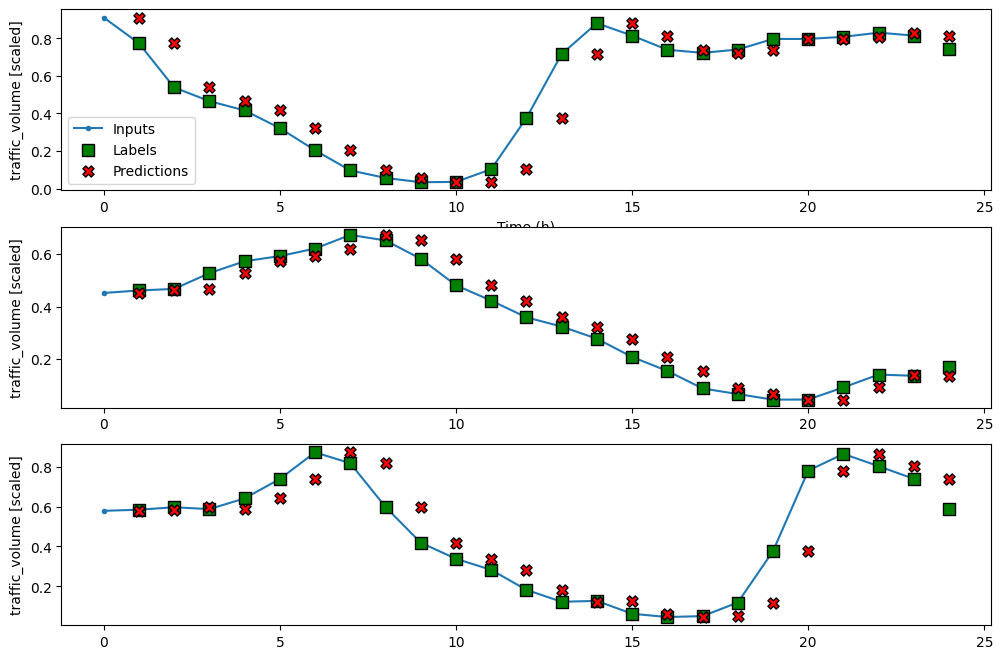

In [8]:
wide_window.plot(baseline_last)

Figura. Predicciones de nuestro modelo básico de un solo paso en tres secuencias de la muestra. La predicción en cada instante de tiempo es el último valor conocido, lo que significa que nuestro modelo básico funciona como se esperaba.

En la figura, las etiquetas son cuadrados y las predicciones son cruces. Las cruces en cada instante son simplemente el último valor conocido, lo que significa que tenemos una línea base que funciona como se espera. Tu gráfico puede diferir de la figura 13.9, ya que el lote de muestras almacenadas cambia cada vez que se inicializa una ventana de datos.

Podemos opcionalmente imprimir el MAE de nuestra línea base en el conjunto de prueba.

In [9]:
print(performance['Baseline - Last'][1])

0.08128400146961212


Esto devuelve un MAE de 0.081. Modelos más complejos deberían funcionar mejor que la línea base, lo que resultaría en un MAE más pequeño.

## Modelo base de multiples pasos

En la sección anterior, creamos un modelo de referencia de un solo paso que simplemente predijo el último valor conocido. Para los modelos de varios pasos, predeciremos más de un paso temporal en el futuro. En este caso, pronosticaremos el volumen de tráfico para las próximas 24 horas de datos con una entrada de 24 horas.

Nuevamente, el primer paso es generar la ventana de datos adecuada. Debido a que deseamos predecir 24 pasos de tiempo en el futuro con una entrada de 24 horas, el ancho de entrada (input_width) es 24, el ancho de la etiqueta (label_width) es 24 y el desplazamiento (shift) es también 24.

In [10]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24,label_columns=['traffic_volume'])

Con la ventana de datos generada, ahora podemos centrarnos en implementar los modelos de referencia. En esta situación, hay dos líneas de base razonables:

- Predice el último valor conocido para los siguientes 24 pasos de tiempo.
- Predice los últimos 24 pasos de tiempo para los próximos 24 pasos de tiempo.

Con eso en mente, implementemos la primera línea de base, donde simplemente repetiremos el último valor conocido durante los próximos 24 pasos de tiempo.

### Predecir el ultimo valor conocido

Para predecir el último valor conocido, definiremos una clase MultiStepLastBaseline que simplemente toma la entrada y repite el último valor de la entrada secuencia de más de 24 pasos de tiempo. Esto actúa como la predicción del modelo.

1. Si no se especifica ningún destino, devuelva el último valor conocido de todas las columnas durante los siguientes 24 pasos de tiempo.
2. Devuelve el último valor conocido de la columna de objetivo durante los siguientes 24 pasos de tiempo.

In [11]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1]) #1
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1]) #2

A continuación inicializaremos la clase y especificaremos la columna de destino. Luego repetiremos los mismos pasos que en la sección anterior, compilando el modelo y evaluándolo en el conjunto de validación y el conjunto de prueba.

In [12]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1881 - mean_absolute_error: 0.3527


Ahora podemos visualizar las predicciones utilizando el método de trazado de DataWindow

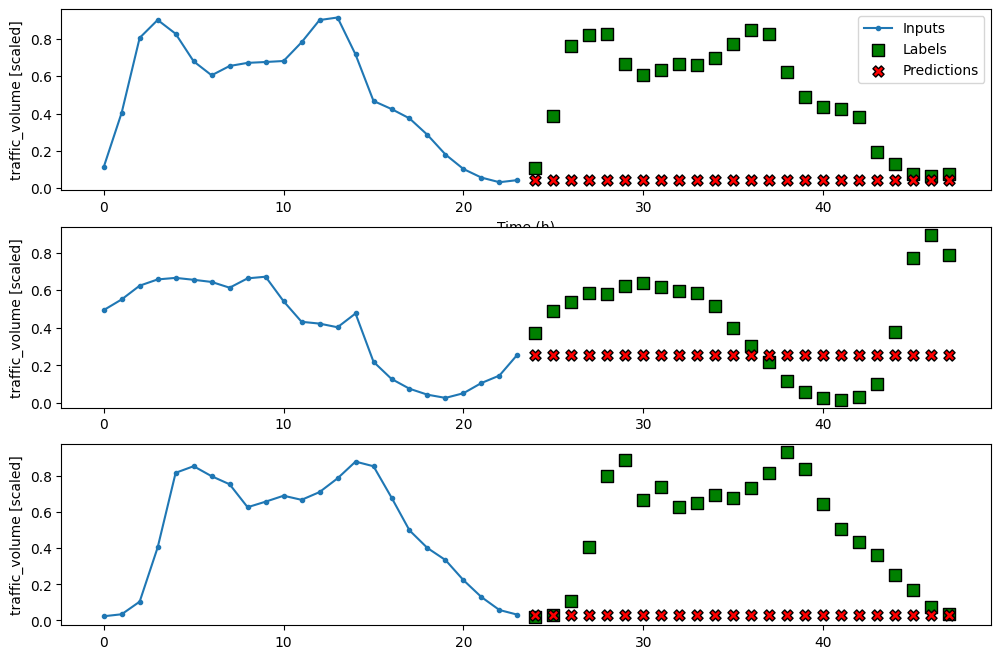

In [13]:
multi_window.plot(ms_baseline_last)

Figura. Prediciendo el último valor conocido para los siguientes 24 pasos de tiempo. Podemos ver que las predicciones, mostradas como cruces, corresponden al último valor de la secuencia de entrada, por lo que nuestra línea base se comporta como se esperaba.

Nuevamente, opcionalmente podemos imprimir el MAE de la línea base. A partir de la figura, podemos esperar que sea bastante alto, ya que existe una gran discrepancia entre las etiquetas y las predicciones.

In [14]:
print(ms_performance['Baseline - Last'][1])

0.34730276465415955


Esto da un MAE de 0,347. Ahora veamos si podemos construir una mejor línea de base simplemente repitiendo la secuencia de entrada.

### Repetir la secuencia de entrada

Implementemos una segunda línea de base para modelos de varios pasos, que simplemente devuelve la secuencia de entrada. Esto significa que la predicción para las próximas 24 horas será simplemente las últimas 24 horas conocidas de datos. Esto se implementa a través de la clase RepeatBaseline.

1. Devuelve la secuencia de entrada para la columna de destino dada.

In [15]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:] # 1

Ahora podemos inicializar el modelo base y generar predicciones. Tenga en cuenta que la función de pérdida y la métrica de evaluación siguen siendo las mismas.

In [16]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_repeat.compile(loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1951 - mean_absolute_error: 0.3356


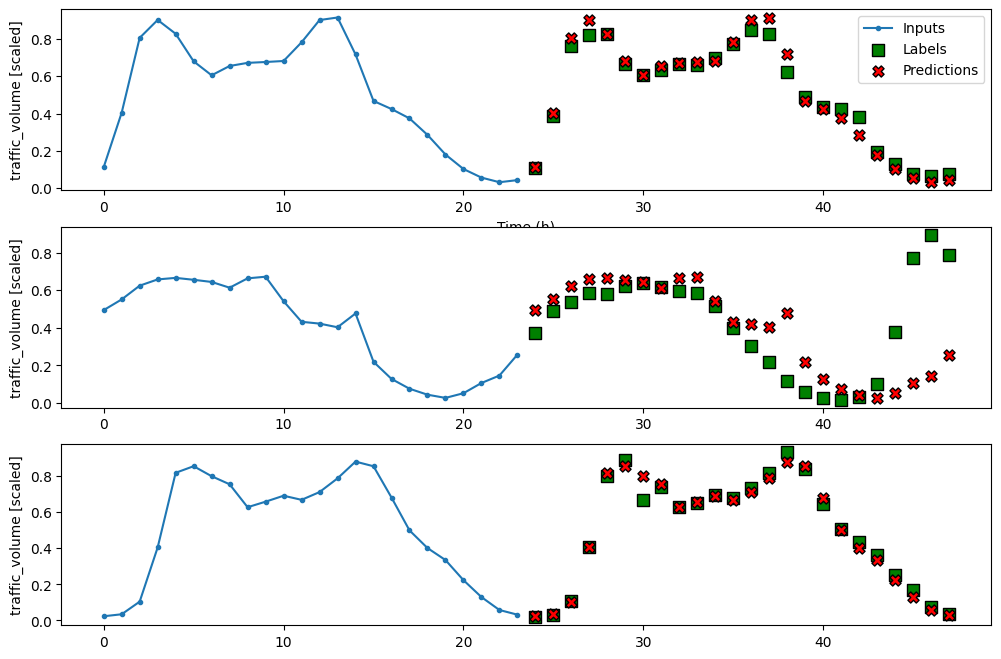

In [17]:
multi_window.plot(ms_baseline_repeat)

Figura. Repitiendo la secuencia de entrada como predicciones. Verá que las predicciones (representadas como cruces) coinciden exactamente con la secuencia de entrada. También notará que muchas predicciones se superponen a las etiquetas, lo que indica que esta línea de base funciona bastante bien.

Esta línea de base funciona bien. Esto es de esperar, ya que identificamos la estacionalidad diaria en el capítulo anterior. Esta línea de base es el equivalente a predecir la última temporada conocida.

Nuevamente, podemos imprimir el MAE en el conjunto de prueba para verificar que efectivamente tenemos una línea de base mejor que simplemente predecir el último valor conocido.

In [18]:
print(ms_performance['Baseline - Repeat'][1])

0.32824525237083435


Esto da un MAE de 0,328, que es menor que el MAE obtenido al predecir el último valor conocido. Por lo tanto, hemos construido con éxito una base mejor.

### Mode base de multiples salidas

El último tipo de modelo que cubriremos es el modelo de multi-salida. En esta situación, deseamos predecir el volumen de tráfico y la temperatura para el siguiente instante de tiempo utilizando un solo punto de datos de entrada. Esencialmente, estamos aplicando el modelo de un solo paso tanto al volumen de tráfico como a la temperatura, convirtiéndolo en un modelo de multi-salida.

Una vez más, comenzaremos definiendo la ventana de datos, pero aquí definiremos dos ventanas: una para el entrenamiento y la otra para la visualización. Dado que el modelo toma un punto de datos y produce una predicción, queremos inicializar una ventana amplia de datos para visualizar muchas predicciones a lo largo de muchos pasos de tiempo.

1. Nótese que pasamos tanto `temp` como `traffic_volume`, ya que esos son nuestros dos objetivos para el modelo de múltiples salidas.

In [23]:
mo_single_step_window = DataWindow(input_width=1, 
                                   label_width=1, 
                                   shift=1,label_columns=['temp','traffic_volume']) #1
mo_wide_window = DataWindow(input_width=24, 
                            label_width=24, 
                            shift=1,label_columns=['temp','traffic_volume'])

Luego utilizaremos la clase Baseline que definimos para el modelo de un solo paso. Recuerda que esta clase puede devolver el último valor conocido para una lista de objetivos.

1. Si no se especifica un objetivo, devolvemos todas las columnas. Esto es útil para modelos de salida múltiple donde se deben predecir todas las columnas.
2. Si especificamos una lista de objetivos, solo devolverá estas columnas especificadas. Nuevamente, esto se utiliza para modelos de múltiples salidas.
3. Devuelve la entrada para una variable objetivo dada.

In [19]:
# Clase para devolver los datos de entrada como una predicción
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs): #1 
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index: #2
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        result = inputs[:, :, self.label_index] #3
        return result[:,:,tf.newaxis]


En el caso del modelo de múltiple salida, simplemente debemos pasar los índices de las columnas de `temp` y `traffic_volume` para obtener el último valor conocido de las respectivas variables como una predicción.

In [20]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

3
1


In [32]:
mo_baseline_last = Baseline(label_index=[1, 3])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

Con la línea base inicializada con nuestras dos variables objetivo, ahora podemos compilar el modelo y evaluarlo.

In [33]:
mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0484


Finalmente, podemos visualizar las predicciones en comparación con los valores reales. De forma predeterminada, nuestro método de graficado mostrará el volumen de tráfico en el eje y, lo que nos permitirá mostrar rápidamente uno de nuestros objetivos.

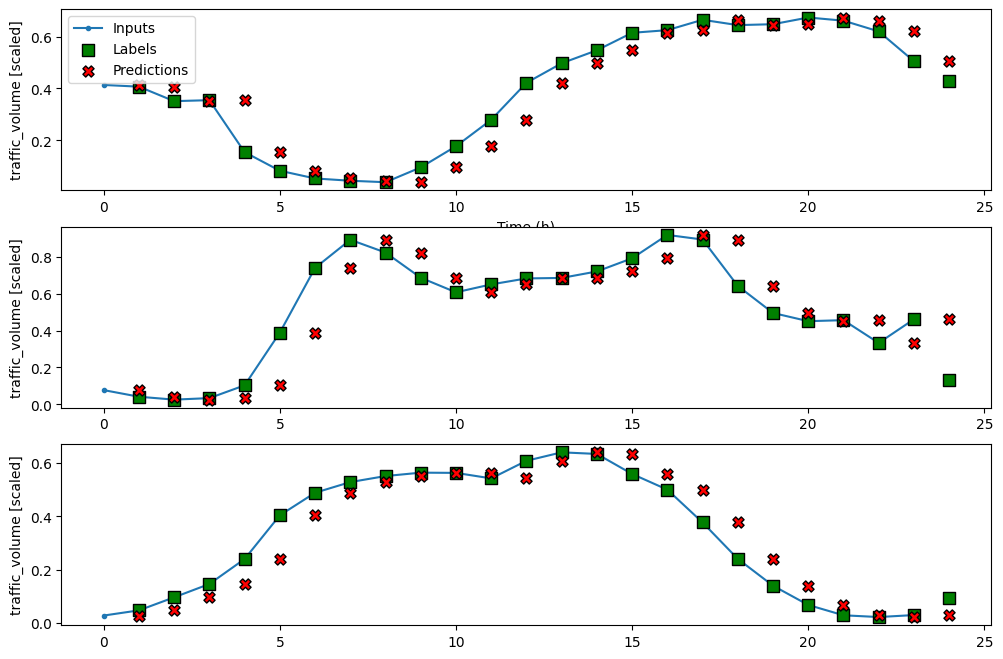

In [34]:
mo_wide_window.plot(mo_baseline_last)

La figura no muestra nada sorprendente, ya que ya vimos estos resultados cuando construimos un modelo base de un solo paso. La particularidad del modelo de múltiples salidas es que también tenemos predicciones para la temperatura. Por supuesto, también podemos visualizar las predicciones para la temperatura especificando el objetivo en el método de trazado.

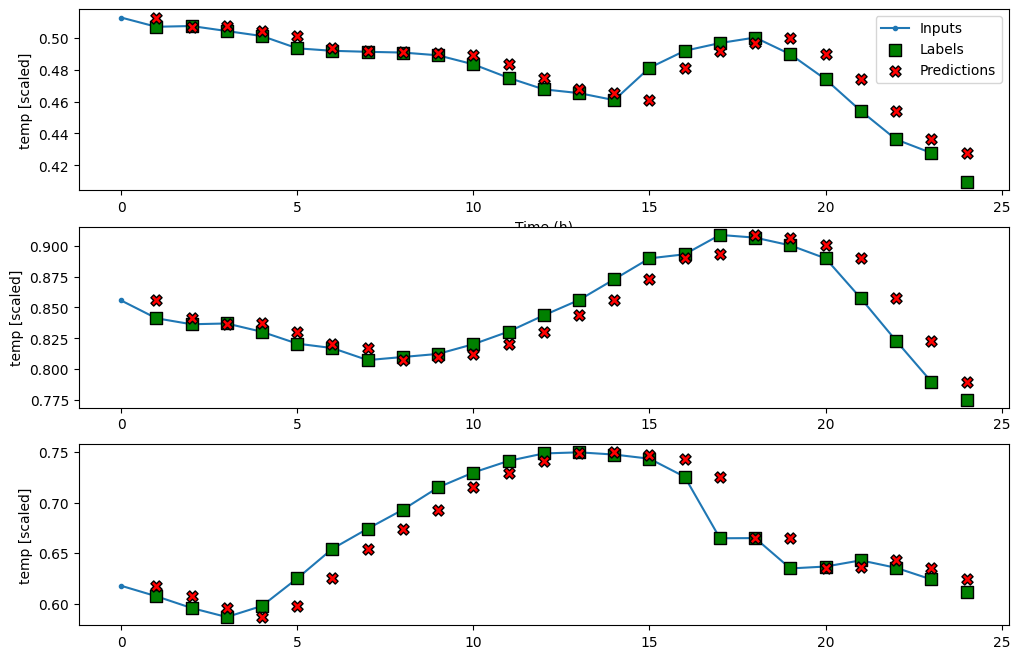

In [35]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

Nuevamente, podemos imprimir el MAE de nuestro modelo base.

In [36]:
print(mo_performance['Baseline - Last'])

[0.006438457872718573, 0.04710666090250015]


Obtenemos un MAE de 0.047 en el conjunto de prueba. En el próximo capítulo, comenzaremos a construir modelos más complejos, y deberían resultar en un MAE más bajo, ya que serán entrenados para ajustarse a los datos.

# Proximos pasos

En este capítulo, cubrimos el paso crucial de crear ventanas de datos, lo que nos permitirá construir rápidamente cualquier tipo de modelo. Luego procedimos a construir modelos de referencia para cada tipo de modelo, de modo que tengamos puntos de comparación a los que podamos referirnos cuando construyamos nuestros modelos más complejos en capítulos posteriores.

Por supuesto, construir modelos de base no es todavía una aplicación de aprendizaje profundo. En el próximo capítulo, implementaremos modelos lineales y redes neuronales profundas, y veremos si esos modelos ya son más eficientes que las simples líneas de base.

# Resumen

- La ventana de datos es esencial en el aprendizaje profundo para formatear los datos como entradas y etiquetas para el modelo.
- La clase DataWindow se puede utilizar fácilmente en cualquier situación y se puede ampliar a su gusto. Úsala en tus propios proyectos.
- Los modelos de aprendizaje profundo requieren una función de pérdida y una métrica de evaluación. En nuestro caso, elegimos el error cuadrático medio (MSE) como la función de pérdida, porque penaliza los errores grandes y tiende a producir modelos más ajustados. La métrica de evaluación es el error absoluto medio (MAE), elegido por su facilidad de interpretación.